# Decision Trees
David John Gagne

* What is a decision tree?
* Decision tree components
* Why are decision trees useful?
* How to grow a classification tree
* How to grow a regression tree
* Strategies for improving performance
* Limitations of decision trees

## What is a decision tree?
A decision tree is a method for recursively partitioning a feature space into hyperrectangles whose contents can be described by a simple model. The splitting rules are organized as a binary tree, which is easy to interpret but limits the kinds of available splits. 
<img src="decision_tree_example.png" width=600>
A tree cannot perform the splits shown in the upper left panel, but it can perform the ones in the upper right panel. The tree structure is shown on the bottom left, and a 3D view of the feature space is shown on the bottom right.


## Decision Tree Components

Decision trees consist of split nodes and leaf nodes. 
Split nodes usually contain a yes-or-no question such as "Is $X_1 \leq 2$?"
Leaf nodes contain a simple model that applies to whatever examples fall into that particular set of conditions. 

Models for classification include:
* The majority class label
* Relative frequencies for each class label

Models for regression include:
* The mean output value of the training examples at that node
* A linear regression fit to the training examples at that node


## Why Are Decision Trees Useful?
* Small decision trees are easily interpretable
* Rules can be extracted
* Can accept numeric and categorial inputs
* Irrelevant features should not be selected by the trees
* Robust to missing data

## How to grow a classification tree
Growing a decision tree requires repeated greedy searches over the training data to find optimal variables and thresholds for splitting the data into subsets. The subsets should have a more uniform set of class labels than the combined data before the split.

How do we select a splitting threshold? One could try every unique value in the training data, but that method is computationally intensive and does not scale well to larger datasets. One could also test a random subset of possible thresholds, which can be effective, but it is not deterministic. In practice, two methods are often used. The simplest is that the mean of the training set values at that node is used. One can also sort the class labels by feature value and identify split points where the class changes. All these split points can then be tested.

What metrics are used to rank the potential splits? The common metrics evaluate some error measure on both child nodes and determine how much the overall error decreased. For a given node $R_m$, the proportion of class $k$ observations $\hat{p}_{mk}$ is calculated.

$\hat{p}_{mk}=\frac{1}{N_m}\sum_{x_i \in R_m}I(y_i=k)$

Entropy: $-\sum_{k=1}^{K} \hat{p}_{mk} log_2(\hat{p}_{mk})$

Gini Index: $-\sum_{k=1}^{K} \hat{p}_{mk} (1-\hat{p}_{mk})$

<img src="entropy.png" width="500px">

Information Gain: $Entropy(R_m) - \frac{N_l}{N_m}Entropy(R_l) - \frac{N_r}{N_m}Entropy(R_r)$ 


In [40]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pandas as pd
import numpy as np
import subprocess
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

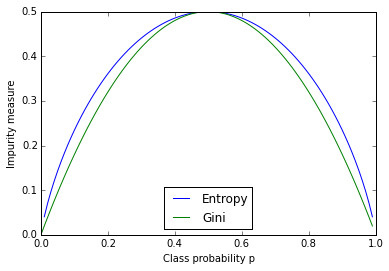

In [91]:
p = np.arange(0, 1, 0.01)
plt.plot(p, 0.5 * (-p * np.log2(p) -(1-p) * np.log2(1-p)), label="Entropy")
plt.plot(p, p * (1 - p) + p * (1-p), label="Gini")
plt.xlabel("Class probability p")
plt.ylabel("Impurity measure")
plt.legend(loc=0)
plt.savefig("./entropy.png", dpi=250, bbox_inches="tight")


## Example: Iris Data

In [61]:
iris_data = load_iris()
training_data = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])
training_data["Label"] = iris_data["target"]


In [64]:
def entropy(labels):
    classes = np.unique(labels)
    entropy = 0
    total_count = labels.size
    for class_label in classes:
        class_count = np.count_nonzero(labels == class_label)
        p = float(class_count) / total_count
        entropy += -p * np.log2(p)
    return entropy

def find_split_points(feature_vals, labels):
    ranking = np.argsort(feature_vals)
    ranked_labels = labels[ranking]
    s_vals = feature_vals[ranking]
    splits = []
    for l in range(len(s_vals)-1):
        if ranked_labels[l] != ranked_labels[l+1] and s_vals[l] not in splits:
            splits.append(s_vals[l])
    return np.array(splits)

total_entropy = entropy(training_data['Label'].values)
print total_entropy
for feature in iris_data['feature_names']:
    #split_val = np.mean(training_data[feature])
    split_vals = find_split_points(training_data[feature].values, training_data["Label"].values)
    for split_val in split_vals:
        left_split = training_data[feature] <= split_val
        left_fraction = float(left_split.sum()) / training_data.shape[0]
        right_split = training_data[feature] > split_val
        right_fraction = float(right_split.sum()) / training_data.shape[0]
        left_entropy = entropy(training_data.loc[left_split, 'Label'].values)
        right_entropy = entropy(training_data.loc[right_split, 'Label'].values)
        gain = total_entropy - left_fraction * left_entropy - right_fraction * right_entropy
        print feature, split_val, total_entropy, left_entropy, right_entropy, gain

1.58496250072
sepal length (cm) 4.8 1.58496250072 0.0 1.5634074324 0.188318527779
sepal length (cm) 4.9 1.58496250072 0.530406077831 1.55118529225 0.18349149325
sepal length (cm) 5.0 1.58496250072 0.644974208757 1.50727055783 0.261648497358
sepal length (cm) 5.1 1.58496250072 0.622983710669 1.4240778913 0.379850352128
sepal length (cm) 5.2 1.58496250072 0.653179162773 1.37797961765 0.424423019533
sepal length (cm) 5.3 1.58496250072 0.643414906711 1.35934882732 0.445166742388
sepal length (cm) 5.4 1.58496250072 0.649609634696 1.23771582313 0.551123489579
sepal length (cm) 5.5 1.58496250072 0.812822306415 1.167065449 0.557232687807
sepal length (cm) 5.6 1.58496250072 0.990588181815 1.16460476979 0.495764919052
sepal length (cm) 5.7 1.58496250072 1.09236790488 1.04669400969 0.516040528708
sepal length (cm) 5.8 1.58496250072 1.22515703851 0.951762675635 0.487389498221
sepal length (cm) 5.9 1.58496250072 1.26593429141 0.941186437182 0.464082250867
sepal length (cm) 6.0 1.58496250072 1.33046

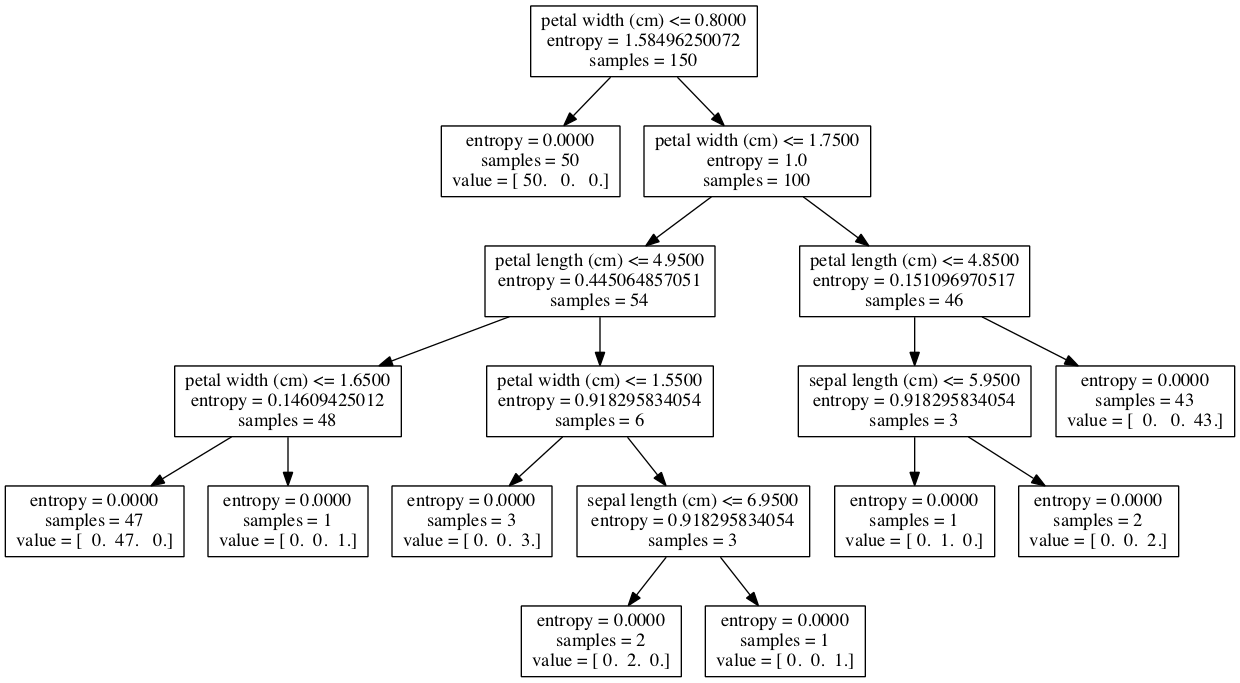

In [103]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=9)
dt.fit(iris_data['data'], iris_data['target'])
export_graphviz(dt, feature_names=iris_data['feature_names'])
subprocess.call("dot -Tpng tree.dot -o tree.png", shell=True)
Image("tree.png",width=800)

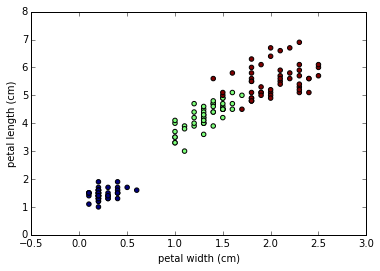

In [94]:
plt.scatter(training_data['petal width (cm)'], training_data['petal length (cm)'],20, training_data['Label'])
plt.xlabel("petal width (cm)")
plt.ylabel("petal length (cm)")

## How to Grow a Regression Tree
Regression trees seek to minimize the error in predicting continuous numeric labels. The feature and split value with the lowest child-node-size-weighted mean squared error is chosen. The predicted label is the mean of the training samples at that node. As with classification trees, the difference in mean squared error between the current node and the weighted sum of the mean squared error at the child nodes is used to evaluate the quality of the split.

## Bias-Variance Tradeoff
When building a statistical model, one must determine the appropriate level of complexity for a given problem. To do so, one must find a balance between reducing the error in predicting the training data values (the bias) and capturing all of the random variability in the training data (the variance). Overly simple models will have smooth (low variance) predictions but higher bias. Overfit models have wildly fluctuating predictions with small changes in the input values (high variance) but will appear to have low training data error. These models will perform poorly on an independent test set as they fit to noise in addition to whatever signal was in the training data. In general, there is some range of optimal model parameter settings that balance these two competing factors. Using a separate validation set or cross-validation for model tuning helps address this tradeoff in practice.

How does this tradeoff apply to decision trees? Larger decision trees (more nodes and levels) tend to fit more closely to smaller sets of data points, but may overfit if the training input values and labels are noisy (which they are with real-world data). Tips for tuning decision trees are below. 

## Strategies for Improving Performance
1. Limiting tree growth  
  1. Pick a maximum depth
  2. Pick a minimum number of training samples at a split or leaf node
  3. Set a minimum gain threshold
2. Pruning
  1. Reduced error pruning: Grow a full tree and then replace branches that have little impact on the error of a validation set.
  2. Rule post-pruning (C4.5, C5, Cubist): Convert decision tree into set of rules and remove parts of rules that improve accuracy. Finally sort rules by estimated accuracy.
3. Trying different splitting criteria
4. Dataset resampling/balancing


## Limitations of Decision Trees
1. Brittleness: small variations of training data can have large impacts on decision tree structure since there are many ways to sub-divide a feature space and achieve similar performance.
2. Low predictive accuracy: single decision trees are usually outperformed by other machine learning methods.
3. Constrained function representation: binary tree structure limits the kinds of functions that can be approximated by a decision tree.
4. High overfitting risk: large trees can easily overfit to training data.

Decision tree ensembles address some of these issues...

## Demo: Hail Prediction with a Decision Tree

In [97]:
hail_data = pd.read_csv("track_step_SSEF_wrf-s4m9_arw_20140604.csv")

In [99]:
hail_data.describe()

,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,Centroid_Lat,uh_max_mean,uh_max_max,uh_max_min,uh_max_std,uh_max_mean_dt,...,weighted_moments_hu_1,weighted_moments_hu_2,weighted_moments_hu_3,weighted_moments_hu_4,weighted_moments_hu_5,weighted_moments_hu_6,Hail_Size,Shape,Location,Scale
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,26.145985,8.102190,2.145985,-90.529773,39.174318,16.523904,60.539652,0.197206,15.746384,-0.833244,...,-9.618788,-15.885709,-17.669873,-27.359603,-16.818854,-18.140143,13.090644,0.494933,2.220805,2.557603
std,5.050539,7.349755,1.597517,7.747519,2.861991,14.344936,45.285409,1.029016,12.011460,9.432909,...,1.471927,1.869413,2.459561,14.237592,10.123037,18.049961,21.773924,0.772210,3.368937,4.524293
min,12.000000,0.000000,1.000000,-105.483620,35.601130,0.027470,0.138520,0.000000,0.041410,-45.735780,...,-14.910410,-20.667790,-22.358960,-44.529430,-33.166980,-42.475830,0.000000,0.000000,0.000000,0.000000
25%,24.000000,2.000000,1.000000,-99.186090,37.319780,6.586620,29.287990,0.000000,7.212700,-2.922700,...,-10.394440,-17.123240,-19.515070,-36.850460,-24.086980,-36.071590,0.000000,0.000000,0.000000,0.000000
50%,26.000000,6.000000,1.000000,-87.401090,38.306610,11.860840,45.701820,0.000000,11.367960,0.000000,...,-9.478860,-15.961650,-17.818160,-32.590900,-20.883740,-28.488010,0.000000,0.000000,0.000000,0.000000
75%,30.000000,12.000000,3.000000,-84.711900,40.008930,22.170760,84.385870,0.000000,22.379080,0.000000,...,-8.783740,-14.729910,-15.861650,-26.804030,-13.418520,0.000000,25.586910,1.273500,6.014260,4.275700
max,36.000000,23.000000,7.000000,-80.240620,50.584500,80.856050,200.518570,8.171900,56.783070,43.749230,...,-5.895990,-10.366450,-10.470490,0.000000,0.000000,0.000000,86.255860,3.398220,12.499610,22.107890


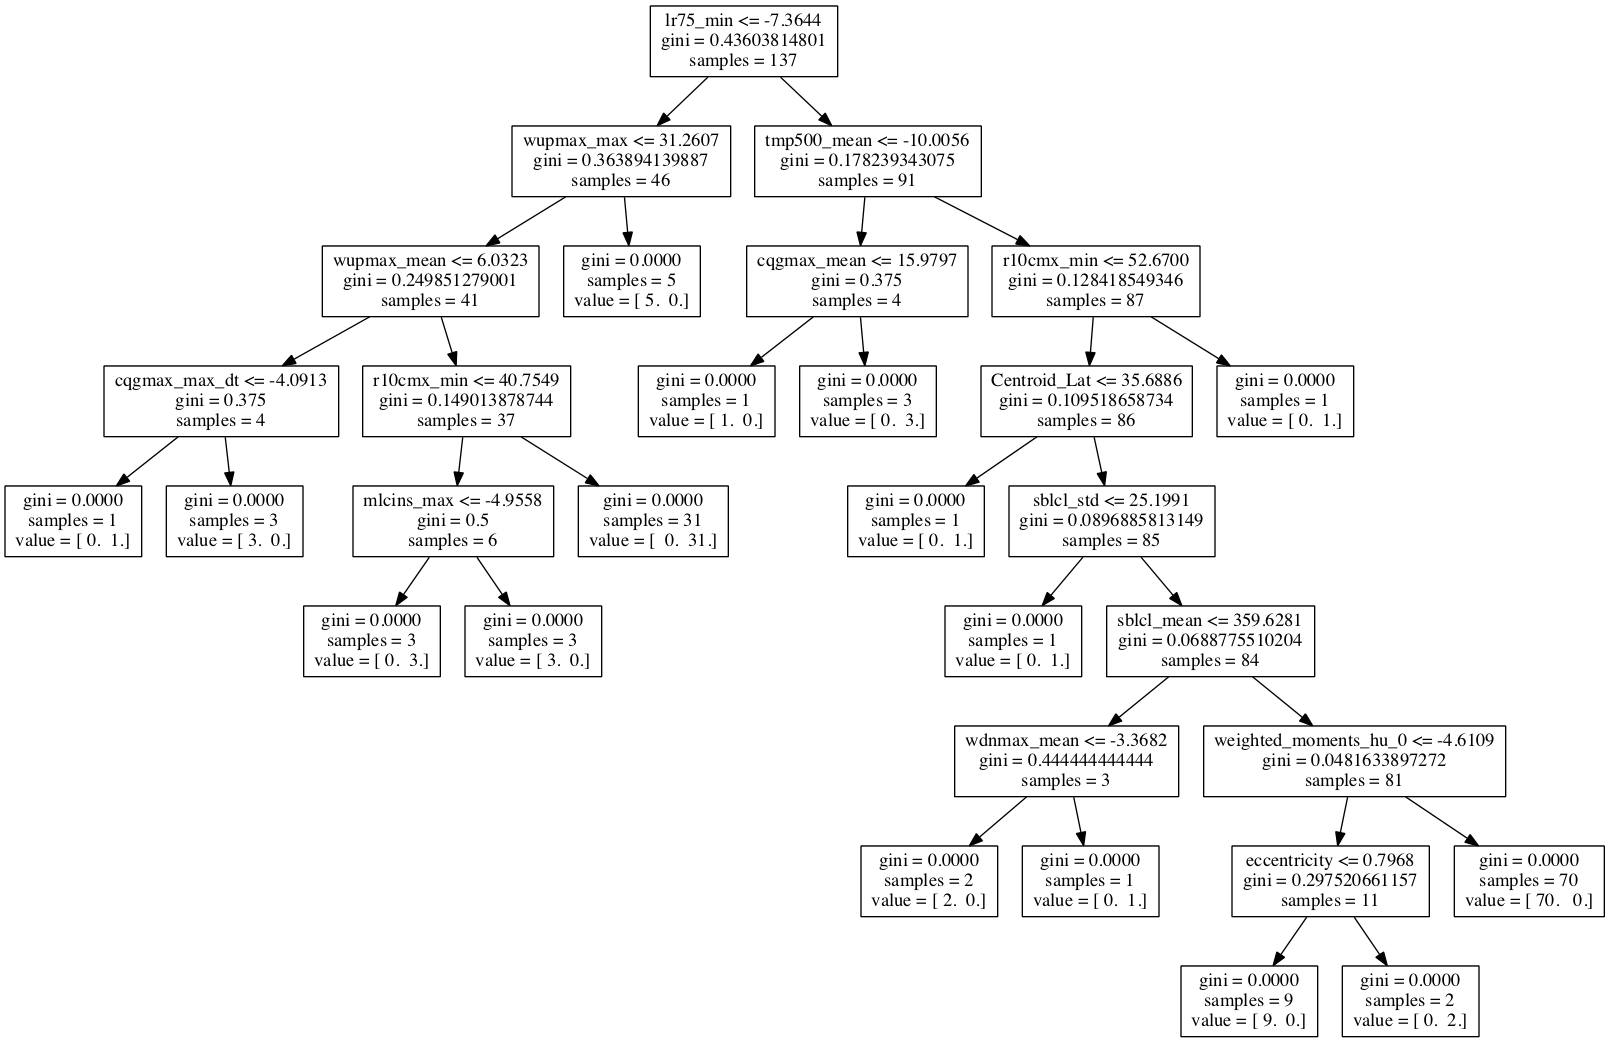

In [102]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(tornado_data.ix[:,5:125], tornado_data.ix[:,"Hail_Size"].values > 0)
export_graphviz(dt, feature_names=tornado_data.columns[5:125], out_file="hail_tree.dot")
subprocess.call("dot -Tpng hail_tree.dot -o hail_tree.png", shell=True)
Image("hail_tree.png",width=800)